# ARIMA SARIMA and SARIMAX Daily Revenue

ARIMA, SARIMA and SARIMAX Roadmap
-------------
1. Helper functions for plotting and error metrics
2. Load libraries and data, set daily frequency
3. Exploratory analysis (seasonality plots, decomposition, ACF/PACF)
4. Stationarity test and differencing
5. ARIMA → SARIMA → SARIMAX (with exogenous regressors)
6. Rolling TimeSeries cross‑validation
7. Parameter tuning (grid over SARIMAX orders)
8. Refit best model on all history and forecast into the future

Key concepts at a glance
------------------------
* Stationarity: distribution (mean/variance/autocovariances) does not change over time.
  - Most ARIMA-type models assume stationarity after differencing (the "d" terms).
* ARIMA(p,d,q): autoregressive (p lags) + differencing d + moving average (q lags).
* SARIMA(p,d,q)×(P,D,Q)_s: adds seasonal AR, differencing, and MA terms with period s
  (e.g., s=7 for weekly seasonality in daily data).
* SARIMAX: SARIMA + eXogenous regressors (a.k.a. dynamic regression) that the model
  uses to improve forecasts (e.g., discount_rate, coupon_rate).
* ACF vs PACF: ACF shows total correlation at lags; PACF shows direct correlation at lags.
* Cross-validation for time series: use forward-chaining splits that respect time order.
* Error metrics: MAE (scale-dependent), RMSE (penalizes large errors), MAPE (scale-free%).

Useful docs
-----------
* SARIMAX: https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html
* TimeSeriesSplit: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html


# Useful Functions

https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html

In [1]:
# Function to assess model and visualize output
def model_assessment(train, test, predictions, chart_title):
  # Set the size of the plot to 10 inches by 4 inches
  plt.figure(figsize = (10,4))
  # Plot the train, test, and forecast data
  plt.plot(train, label = 'Train')
  plt.plot(test, label = 'Test')
  plt.plot(predictions, label = "Forecast")
  # add title and legend to the plot
  plt.title(f"Train, Test and Predictions with {chart_title}")
  plt.legend()
  plt.show()

  # Calculating the MAE, RMSE, and MAPE
  mae = mean_absolute_error(test, predictions)
  rmse = root_mean_squared_error(test, predictions)
  mape = mean_absolute_percentage_error(test, predictions)

  # Print the calculated error metrics
  print(f"The MAE is {mae:.2f}")
  print(f"The RMSE is {rmse:.2f}")
  print(f"The MAPE is {100 * mape:.2f} %")

In [2]:
# Function to plot the future
def plot_future(y, forecast, title):
  # Set the size of the plot to 10 inches by 4 inches
  plt.figure(figsize = (10,4))
  # Plot the train and forecast data
  plt.plot(y, label = 'Train')
  plt.plot(forecast, label = "Forecast")
  # add title and legend to the plot
  plt.title(f"Train and Forecast with {title}")
  plt.legend()
  plt.show()

# Libraries and Data

In [3]:
# Mount Google Drive
#from google.colab import drive
# drive.mount('/content/drive')

In [4]:
%cd '/Users/tanojudawattage/1_tanoj/0.00_Cloud_Computing_and_Streaming_Tech/Python_Time_Series_Exercise_Files/Time Series Analysis/ARIMA, SARIMA and SARIMAX'

/Users/tanojudawattage/1_tanoj/0.00_Cloud_Computing_and_Streaming_Tech/Python_Time_Series_Exercise_Files/Time Series Analysis/ARIMA, SARIMA and SARIMAX


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import (
    month_plot,
    quarter_plot,
    plot_acf,
    plot_pacf
)
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller # Check for stationarity
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import (
    mean_absolute_error,
    root_mean_squared_error,
    mean_absolute_percentage_error)
from sklearn.model_selection import ParameterGrid
import numpy as np

In [6]:
# Loading the daily revenue data and set the date as uindex
df = pd.read_csv("daily_revenue.csv",
                 index_col = "date",
                 parse_dates = True,
                 dayfirst = True)
df.head()

,revenue,discount_rate,coupon_rate
date,,,
2018-01-01,"6,270,839",34.27%,1.09%
2018-01-02,"8,922,076",30.87%,1.08%
2018-01-03,"8,446,101",28.11%,1.01%
2018-01-04,"7,785,798",27.32%,0.96%
2018-01-05,"6,375,303",25.70%,0.90%


In [7]:
# Information about the df
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1795 entries, 2018-01-01 to 2022-11-30
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   revenue        1795 non-null   object
 1   discount_rate  1795 non-null   object
 2   coupon_rate    1795 non-null   object
dtypes: object(3)
memory usage: 56.1+ KB


In [8]:
# Remove the comma in revenue (Dtype is object) and convert it as float
df['revenue'] = df['revenue'].str.replace(",", "").astype(float)
df.head(2)

,revenue,discount_rate,coupon_rate
date,,,
2018-01-01,6270839.0,34.27%,1.09%
2018-01-02,8922076.0,30.87%,1.08%


In [9]:
# Set the dataframe to have daily frequency
df = df.asfreq("D")

In [10]:
# Change the time Series variable name
df = df.rename(columns = {'revenue': 'y'})
df.head()

,y,discount_rate,coupon_rate
date,,,
2018-01-01,6270839.0,34.27%,1.09%
2018-01-02,8922076.0,30.87%,1.08%
2018-01-03,8446101.0,28.11%,1.01%
2018-01-04,7785798.0,27.32%,0.96%
2018-01-05,6375303.0,25.70%,0.90%


A list of commonly used `.asfreq()` aliases:

Time-based frequencies:

- 'D': Calendar day frequency
- 'B': Business day frequency
- 'W': Weekly frequency
- 'W-MON', 'W-TUE', ..., 'W-SUN': Weekly frequency (anchored on a specific day)
- 'ME': Month end frequency
- 'MS': Month start frequency
- 'Q': Quarter end frequency
- 'QS': Quarter start frequency
- 'A' or 'Y': Year end frequency
- 'BA' or 'BY': Business year end frequency
- 'AS' or 'YS': Year start frequency
- 'BAS' or 'BYS': Business year start frequency


Hourly, minutely, and secondly frequencies:

- 'H': Hourly frequency
- 'T' or 'min': Minutely frequency
- 'S': Secondly frequency


You can also use multiples, like:

- '2D': Every 2 days
- '4H': Every 4 hours
- '15T' or '15min': Every 15 minutes

# Exploratory Data Analysis

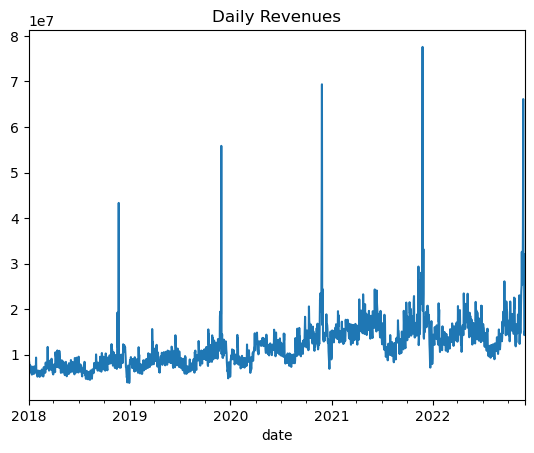

In [11]:
# Daily revenues line plot
df['y'].plot(title = 'Daily Revenues')
plt.show()

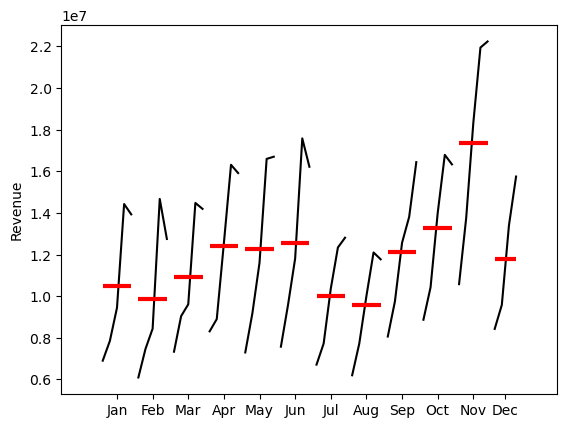

In [12]:
# month_plot() - To visualize the average value for each month across multiple years in a time series
# red lines - Represents the mean value for each month

# Plotting the monthly seasonality of revenue values
month_plot(df['y'].resample('ME').mean(),
           ylabel = 'Revenue')
plt.show()

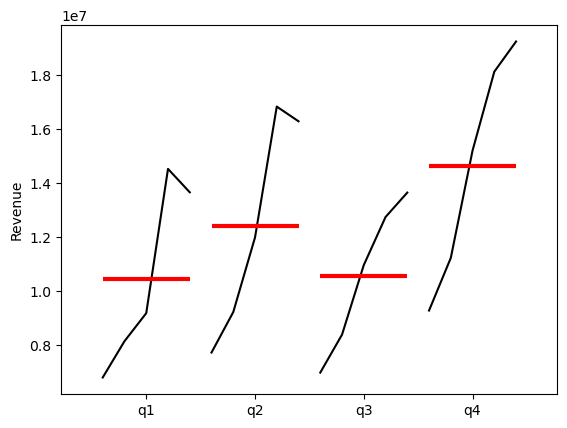

In [13]:
# quarter_plot() - To visualize seasonal patterns at a quarterly level.
# Q1 (january, february, march), Q2 (april, may, june), Q3 (july, august, september), Q4 (october, november, december)

# Plotting the quarterly seasonality of revenue values
# .resample('Q') - to convert the time series data into quarterly seasonality
quarter_plot(df['y'].resample('QE').mean(),
           ylabel = 'Revenue')
plt.show()

`seasonal_decompose` - To decompose a time series into its constituent parts to better understand the underlying patterns.

components

- Trend: The overall direction of the series (increasing, decreasing, or stable).
- Seasonal: Repeating patterns at fixed intervals (e.g., daily, weekly, monthly).
- Residual: The remaining variation after removing trend and seasonal components.

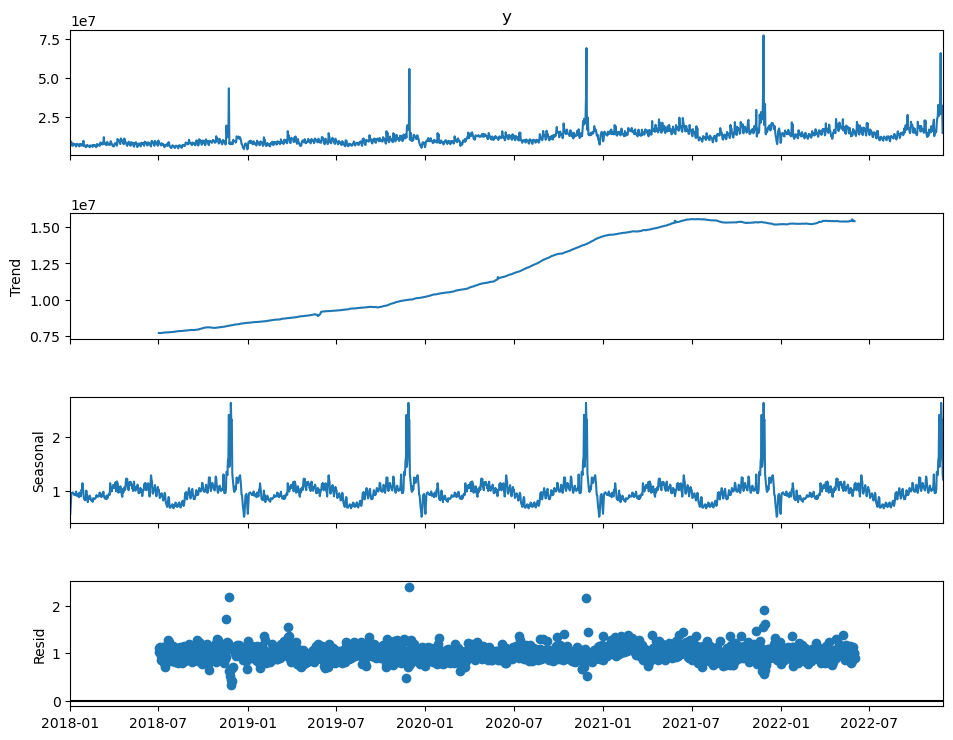

In [14]:
# Seasonal Decomposition Plots for Revenue Data
# Multiplicative model type, with daily seasonality (365 days)
decomposition = seasonal_decompose(df['y'],
                                   model = 'mul',
                                   period = 365)
fig = decomposition.plot()
fig.set_size_inches(10,8)
plt.show()

Autocorrelation measures the correlation between a time series and a lagged version of itself.

Purpose: To identify patterns or repeating cycles in a time series dataset.

Interpretation:
- Values range from -1 to 1.
- 1 indicates perfect positive correlation.
- -1 indicates perfect negative correlation.
- 0 indicates no correlation.

ACF Plot:
- X-axis: Lag periods
- Y-axis: Correlation coefficient

Key Features:
- At lag 0, autocorrelation is always 1 (a series is perfectly correlated with itself).
- Significant spikes at certain lags indicate repeating patterns.


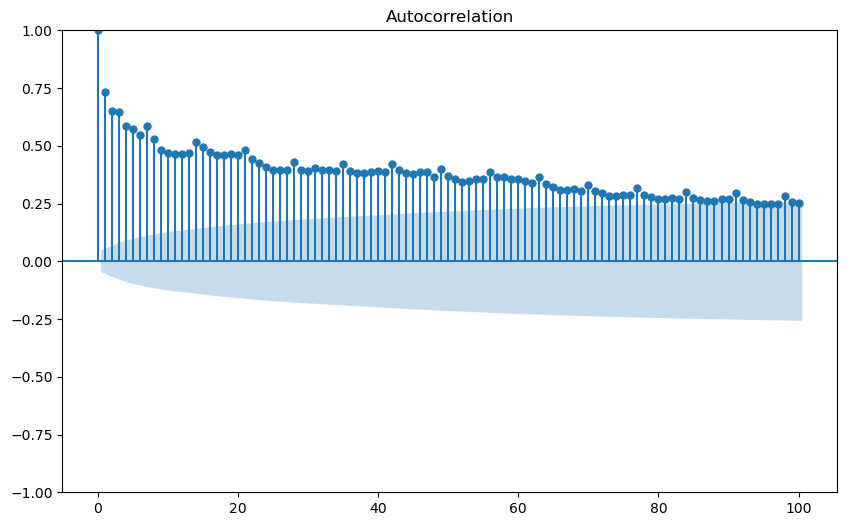

In [15]:
# Plot the autocorrelation (ACF) of revenue values
fig, ax = plt.subplots(figsize = (10,6))
plot_acf(df['y'], lags = 100, ax = ax)
plt.show()

PACF measures the correlation between a time series and its lag, after removing the effects of all shorter lags.

Purpose: To identify the direct relationship between an observation and its lag, without intermediate effects.

Main Difference between ACF and PACF:
- ACF: Measures overall correlation at each lag, including indirect effects.
- PACF: Measures direct correlation at each lag, excluding indirect effects.

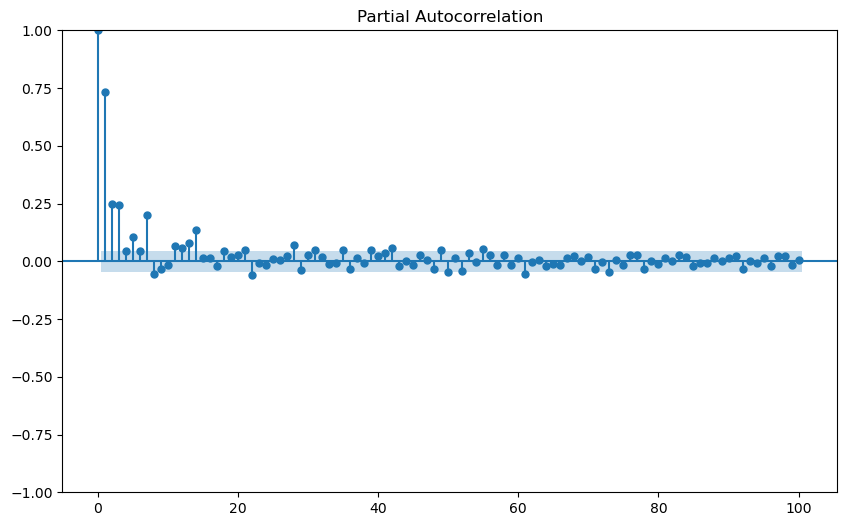

In [16]:
# Plot the partial autocorrelation (PACF) of revenue values
fig, ax = plt.subplots(figsize = (10,6))
plot_pacf(df['y'], lags = 100, ax = ax)
plt.show()

# Stationarity

Fail to reject the null hypothesis or accept the altrenative hypothesis. 
The null hypothesis is that the time series is NOT stationary (i.e. most cases, time series is not stationary). 
* If p-value is above 0.05, the time series is NOT stationary. 
* If p-value is below 0.05, the time series is starionary.

In [17]:
# Perform the Augmented Dickey-Fuller (ADF) test (adfuller test - to check for stationarity)
result = adfuller(df.y)
# Print the p-value from the ADF test
print(f'p-value: {result[1]}')

if result[1] > 0.05:
    print("The time series is NOT stationary.")
else:
    print("The time series is stationary.")

p-value: 0.10190360862386194
The time series is NOT stationary.


In [18]:
# Differencing for df.y
df['y_diff'] = df['y'] - df['y'].shift(1)
df.head()

,y,discount_rate,coupon_rate,y_diff
date,,,,
2018-01-01,6270839.0,34.27%,1.09%,NaN
2018-01-02,8922076.0,30.87%,1.08%,2651237.0
2018-01-03,8446101.0,28.11%,1.01%,-475975.0
2018-01-04,7785798.0,27.32%,0.96%,-660303.0
2018-01-05,6375303.0,25.70%,0.90%,-1410495.0


In [19]:
# Check if the maths works
8922076.0 - 6270839.0

2651237.0

In [20]:
# Test if the differenced series is stationary
result_diff = adfuller(df['y_diff'].dropna())
print(f'p-value: {result_diff[1]}')

p-value: 6.5137920268182164e-24


# ARIMA

In [21]:
# Split the data into training and test
test_days = 30
train = df.iloc[:-test_days]
test = df.iloc[-test_days:]
test.head()

,y,discount_rate,coupon_rate,y_diff
date,,,,
2022-11-01,16703680.0,23.85%,1.50%,4014654.0
2022-11-02,15827022.0,20.76%,0.94%,-876658.0
2022-11-03,16154319.0,21.85%,0.92%,327297.0
2022-11-04,14707212.0,20.17%,0.88%,-1447107.0
2022-11-05,14877530.0,17.85%,0.41%,170318.0


In [22]:
# Create and fit the ARIMA model
model = SARIMAX(train['y'], 
                order=(3, 1, 1), 
                seasonal_order=(0, 0, 0, 0)).fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1765
Model:               SARIMAX(3, 1, 1)   Log Likelihood              -28828.653
Date:                Fri, 31 Oct 2025   AIC                          57667.306
Time:                        09:43:11   BIC                          57694.682
Sample:                    01-01-2018   HQIC                         57677.422
                         - 10-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3563      0.014     24.733      0.000       0.328       0.385
ar.L2          0.0237      0.020      1.195      0.232      -0.015       0.062
ar.L3          0.1274      0.022      5.804      0.0

In [23]:
# Predicrt with the ARIMA model
predictions = model.forecast(steps = test_days)
predictions

2022-11-01    1.412691e+07
2022-11-02    1.494030e+07
2022-11-03    1.502568e+07
2022-11-04    1.525848e+07
2022-11-05    1.544705e+07
2022-11-06    1.553061e+07
2022-11-07    1.559450e+07
2022-11-08    1.564325e+07
2022-11-09    1.567278e+07
2022-11-10    1.569259e+07
2022-11-11    1.570655e+07
2022-11-12    1.571576e+07
2022-11-13    1.572189e+07
2022-11-14    1.572607e+07
2022-11-15    1.572888e+07
2022-11-16    1.573076e+07
2022-11-17    1.573203e+07
2022-11-18    1.573289e+07
2022-11-19    1.573346e+07
2022-11-20    1.573385e+07
2022-11-21    1.573411e+07
2022-11-22    1.573428e+07
2022-11-23    1.573440e+07
2022-11-24    1.573448e+07
2022-11-25    1.573453e+07
2022-11-26    1.573457e+07
2022-11-27    1.573459e+07
2022-11-28    1.573461e+07
2022-11-29    1.573462e+07
2022-11-30    1.573462e+07
Freq: D, Name: predicted_mean, dtype: float64

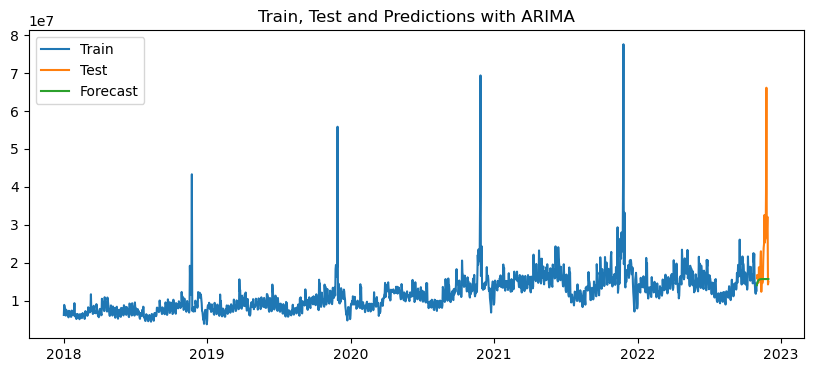

The MAE is 7276324.45
The RMSE is 12374873.11
The MAPE is 24.18 %


In [24]:
# Visualize the forecast and assess the model
model_assessment(train['y'], test['y'], predictions, "ARIMA")

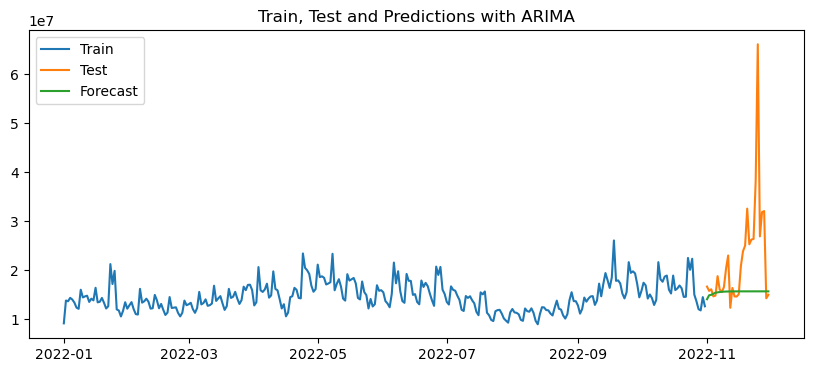

The MAE is 7276324.45
The RMSE is 12374873.11
The MAPE is 24.18 %


In [25]:
# Visualize the forecast and assess the model for 2022 only
model_assessment(train['y']['2022'], test['y'], predictions, "ARIMA")

# SARIMA

In [26]:
# Building the SARIMA Model
model_sarima = SARIMAX(
    train['y'], 
    order = (3, 1, 1), 
    seasonal_order = (2, 0, 1, 7)).fit() # Test with 356 instead of 7
print(model_sarima.summary())

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                 1765
Model:             SARIMAX(3, 1, 1)x(2, 0, 1, 7)   Log Likelihood              -28738.552
Date:                           Fri, 31 Oct 2025   AIC                          57493.104
Time:                                   09:43:16   BIC                          57536.907
Sample:                               01-01-2018   HQIC                         57509.290
                                    - 10-31-2022                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4376      0.008     54.411      0.000       0.422       0.453
ar.L2          0.0599      0.015      3.954

In [27]:
# Predict with the SARIMA model
predictions_sarima = model_sarima.forecast(steps = test_days)

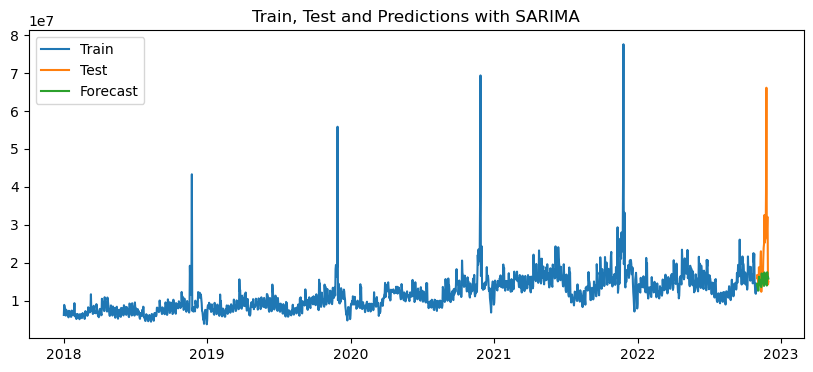

The MAE is 7609232.83
The RMSE is 12607881.24
The MAPE is 25.90 %


In [28]:
# Assess and visualize the SARIMA model
model_assessment(train['y'], test['y'], predictions_sarima, "SARIMA")

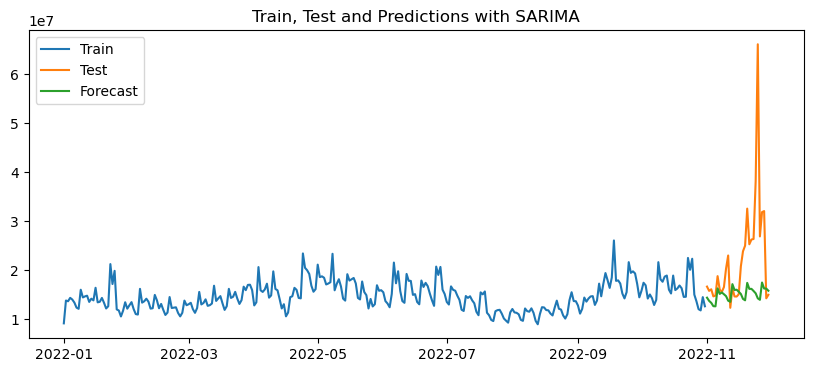

The MAE is 7609232.83
The RMSE is 12607881.24
The MAPE is 25.90 %


In [29]:
# Assess and visualize the SARIMA model for 2022 only   
model_assessment(train['y']['2022'], test['y'], predictions_sarima, "SARIMA")

# SARIMAX

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1795 entries, 2018-01-01 to 2022-11-30
Freq: D
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   y              1795 non-null   float64
 1   discount_rate  1795 non-null   object 
 2   coupon_rate    1795 non-null   object 
 3   y_diff         1794 non-null   float64
dtypes: float64(2), object(2)
memory usage: 70.1+ KB


In [31]:
# Remove the % symbol from the discount_rate column and convert it to float
df['discount_rate'] = df['discount_rate'].str.replace('%', '').astype(float)
df.head()

,y,discount_rate,coupon_rate,y_diff
date,,,,
2018-01-01,6270839.0,34.27,1.09%,NaN
2018-01-02,8922076.0,30.87,1.08%,2651237.0
2018-01-03,8446101.0,28.11,1.01%,-475975.0
2018-01-04,7785798.0,27.32,0.96%,-660303.0
2018-01-05,6375303.0,25.70,0.90%,-1410495.0


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1795 entries, 2018-01-01 to 2022-11-30
Freq: D
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   y              1795 non-null   float64
 1   discount_rate  1795 non-null   float64
 2   coupon_rate    1795 non-null   object 
 3   y_diff         1794 non-null   float64
dtypes: float64(3), object(1)
memory usage: 70.1+ KB


In [39]:
df['coupon_rate'] = df['coupon_rate'].str.replace('%', '').astype(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1795 entries, 2018-01-01 to 2022-11-30
Freq: D
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   y              1795 non-null   float64
 1   discount_rate  1795 non-null   float64
 2   coupon_rate    1795 non-null   float64
 3   y_diff         1794 non-null   float64
dtypes: float64(4)
memory usage: 70.1 KB


In [40]:
# Split the regressor data into training and test
train_reg = df[["discount_rate", "coupon_rate"]][:-test_days]
test_reg = df[["discount_rate", "coupon_rate"]][-test_days:]

In [41]:
# Build the SARIMAX model
model_sarimax = SARIMAX(
    train['y'], 
    exog = train_reg,
    order = (3, 1, 1), 
    seasonal_order = (2, 0, 1, 7)).fit()
print(model_sarimax.summary())

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                 1765
Model:             SARIMAX(3, 1, 1)x(2, 0, 1, 7)   Log Likelihood              -28595.060
Date:                           Fri, 31 Oct 2025   AIC                          57210.121
Time:                                   09:46:51   BIC                          57264.874
Sample:                               01-01-2018   HQIC                         57230.353
                                    - 10-31-2022                                         
Covariance Type:                             opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
discount_rate   4.03e+05   1.56e-08   2.59e+13      0.000    4.03e+05    4.03e+05
coupon_rate    9.229e+05   7.46e-0

In [42]:
# Predict with SARIMAX
predictions_sarimax = model_sarimax.forecast(steps = test_days,
                                                exog = test_reg)

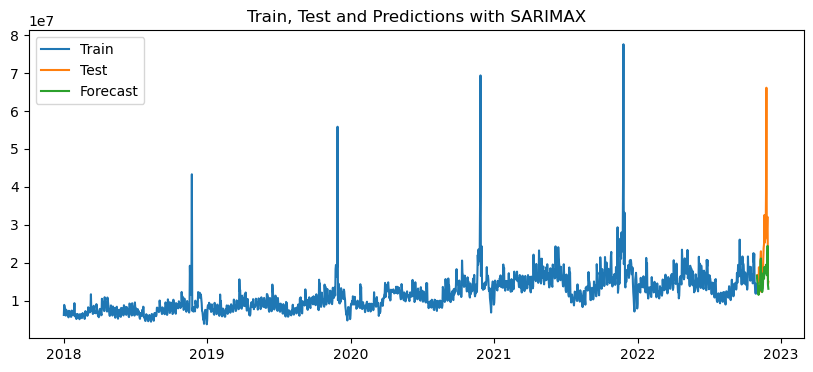

The MAE is 6305105.02
The RMSE is 10955239.34
The MAPE is 21.71 %


In [43]:
# Model assessment and vdisualization for SARIMAX
model_assessment(train['y'], test['y'], predictions_sarimax, "SARIMAX")

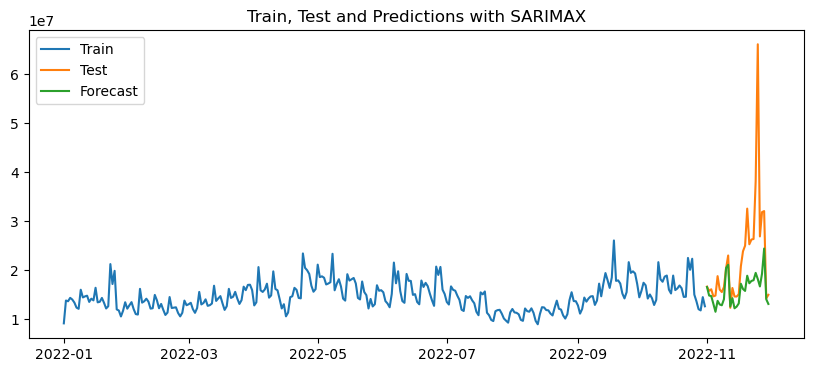

The MAE is 6305105.02
The RMSE is 10955239.34
The MAPE is 21.71 %


In [44]:
# Model assessment and vdisualization for SARIMAX for 2022 only
model_assessment(train['y']['2022'], test['y'], predictions_sarimax, "SARIMAX")

Becasue we have weekly seasonality, we missed on yearly (Christmas, Thanksgiving, Black Friday)
-- Add variables to represent those events

# Cross Validation

TimeSeriesSplit: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html

In [45]:
# Define the configuration for cross validation
order = (3, 1, 1)
seasonal_order = (2, 0, 1, 7)
n_splits = 5

In [46]:
# Import the module
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=n_splits, test_size=test_days)



In [47]:
# How many periods in the df
len(df)

1795

In [48]:
# Inspect the time series splits
for train_index, test_index in tscv.split(df):
    print('TRAIN:', train_index, 'TEST:', test_index)

TRAIN: [   0    1    2 ... 1642 1643 1644] TEST: [1645 1646 1647 1648 1649 1650 1651 1652 1653 1654 1655 1656 1657 1658
 1659 1660 1661 1662 1663 1664 1665 1666 1667 1668 1669 1670 1671 1672
 1673 1674]
TRAIN: [   0    1    2 ... 1672 1673 1674] TEST: [1675 1676 1677 1678 1679 1680 1681 1682 1683 1684 1685 1686 1687 1688
 1689 1690 1691 1692 1693 1694 1695 1696 1697 1698 1699 1700 1701 1702
 1703 1704]
TRAIN: [   0    1    2 ... 1702 1703 1704] TEST: [1705 1706 1707 1708 1709 1710 1711 1712 1713 1714 1715 1716 1717 1718
 1719 1720 1721 1722 1723 1724 1725 1726 1727 1728 1729 1730 1731 1732
 1733 1734]
TRAIN: [   0    1    2 ... 1732 1733 1734] TEST: [1735 1736 1737 1738 1739 1740 1741 1742 1743 1744 1745 1746 1747 1748
 1749 1750 1751 1752 1753 1754 1755 1756 1757 1758 1759 1760 1761 1762
 1763 1764]
TRAIN: [   0    1    2 ... 1762 1763 1764] TEST: [1765 1766 1767 1768 1769 1770 1771 1772 1773 1774 1775 1776 1777 1778
 1779 1780 1781 1782 1783 1784 1785 1786 1787 1788 1789 1790 1791 17

In [49]:
# Perform the time series cross-validation and assess based on RMES, MAE and MAPE
cv_scores = []
for train_index, test_index in tscv.split(df):
    train = df.iloc[train_index]
    test = df.iloc[test_index]

    # Retrieve the exog data
    train_reg = df[["discount_rate", "coupon_rate"]].iloc[train_index]
    test_reg = df[["discount_rate", "coupon_rate"]].iloc[test_index]

    # Build the SARIMAX model
    model_sarima = SARIMAX(
        train['y'], 
        exog = train_reg,
        order = order, 
        seasonal_order = seasonal_order).fit()
    
    # Make the predictions with SARIMAX
    predictions_sarimax = model_sarimax.forecast(steps = test_days,
                                                 exog = test_reg)
    
    # Assess the predictions
    rmse = root_mean_squared_error(test['y'], predictions_sarimax)
    mae = mean_absolute_error(test['y'], predictions_sarimax)
    mape = mean_absolute_percentage_error(test['y'], predictions_sarimax)

    # Store the predictions
    cv_scores.append({
        'rmse': rmse,
        'mae': mae,
        'mape': mape
    })

/opt/anaconda3/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [50]:
# aggregate and display the results
cv_scores = pd.DataFrame(cv_scores)
cv_scores.index.name = 'Fold'
cv_scores

,rmse,mae,mape
Fold,,,
0,3.314723e+06,2.868171e+06,0.249151
1,3.271242e+06,3.000976e+06,0.264034
2,3.913126e+06,3.009042e+06,0.170426
3,3.003784e+06,2.581070e+06,0.154367
4,1.095524e+07,6.305105e+06,0.217083


In [51]:
# Print the average errors
print(f"Average RMSE: {cv_scores['rmse'].mean():.2f}")
print(f"Average MAE: {cv_scores['mae'].mean():.2f}")
print(f"Average MAPE: {100 * cv_scores['mape'].mean():.2f} %")


Average RMSE: 4891622.99
Average MAE: 3552872.71
Average MAPE: 21.10 %


# Parameter Tuining

In [56]:
# Define the parameter options
param_grid = {
    'p' : [1, 3],
    'd' : [1],
    'q' : [0, 1],
    'P' : [1, 2],
    'D' : [0],
    'Q' : [1]
}

# Apply parameter grid
grid = ParameterGrid(param_grid)
list(grid)

[{'D': 0, 'P': 1, 'Q': 1, 'd': 1, 'p': 1, 'q': 0},
 {'D': 0, 'P': 1, 'Q': 1, 'd': 1, 'p': 1, 'q': 1},
 {'D': 0, 'P': 1, 'Q': 1, 'd': 1, 'p': 3, 'q': 0},
 {'D': 0, 'P': 1, 'Q': 1, 'd': 1, 'p': 3, 'q': 1},
 {'D': 0, 'P': 2, 'Q': 1, 'd': 1, 'p': 1, 'q': 0},
 {'D': 0, 'P': 2, 'Q': 1, 'd': 1, 'p': 1, 'q': 1},
 {'D': 0, 'P': 2, 'Q': 1, 'd': 1, 'p': 3, 'q': 0},
 {'D': 0, 'P': 2, 'Q': 1, 'd': 1, 'p': 3, 'q': 1}]

In [57]:
len(list(grid))

8

In [58]:
# Do the time series splits
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits, test_size=test_days)

In [61]:
# Perform the paremeter tuning 
rmse_list = []

# Iterate through the parameters
for params in grid:
    fold_rmse = []

    # Build the model
    for train_index, test_index in tscv.split(df):
        train = df.iloc[train_index]
        test = df.iloc[test_index]

        # Isolate the regressors
        train_reg = df[["discount_rate", "coupon_rate"]].iloc[train_index]
        test_reg = df[["discount_rate", "coupon_rate"]].iloc[test_index]

        # Build the SARIMAX model
        model_sarima = SARIMAX(
            train['y'], 
            exog = train_reg,
            order = (params['p'], params['d'], params['q']), 
            seasonal_order = (params['P'], params['D'], params['Q'], 7)).fit()

        # Calculate the error and store the results
        predictions_sarimax = model_sarima.forecast(steps = test_days,
                                                     exog = test_reg)
        rmse = root_mean_squared_error(test['y'], predictions_sarimax)
        fold_rmse.append(rmse)

    # Store the results
    rmse_list.append(np.mean(fold_rmse))


/opt/anaconda3/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [62]:
# Check the output - aggregate the rmse to the grid and transform to a df
rmse_df = pd.DataFrame(list(grid))
rmse_df['rmse'] = rmse_list
rmse_df

,D,P,Q,d,p,q,rmse
0,0,1,1,1,1,0,4.353137e+06
1,0,1,1,1,1,1,4.534559e+06
2,0,1,1,1,3,0,4.383700e+06
3,0,1,1,1,3,1,4.536421e+06
4,0,2,1,1,1,0,4.346101e+06
5,0,2,1,1,1,1,4.530510e+06
6,0,2,1,1,3,0,4.374348e+06
7,0,2,1,1,3,1,4.527626e+06


In [64]:
# Extract the best parameters
best_params = rmse_df.sort_values(by='rmse').iloc[0].to_dict()
best_params

{'D': 0.0,
 'P': 2.0,
 'Q': 1.0,
 'd': 1.0,
 'p': 1.0,
 'q': 0.0,
 'rmse': 4346100.53508387}

In [66]:
# Extract the minimum best parameters
best_params = rmse_df.loc[rmse_df['rmse'].idxmin()]
best_params.to_csv('best_params_sarimax.csv')

# Predicting the future

In [67]:
# Isolate X and y
y = df["y"]
X = df[["discount_rate", "coupon_rate"]]

In [69]:
# Fetch the best parameters
p = int(best_params.loc['p'])
d = int(best_params.loc['d'])
q = int(best_params.loc['q'])
P = int(best_params.loc['P'])
D = int(best_params.loc['D'])
Q = int(best_params.loc['Q'])

In [74]:
# Load the futre regressors df
future_reg = pd.read_csv("future_regressors.csv",
                                index_col = 0,
                                dayfirst = True,
                                parse_dates= True)
future_reg.head()

,revenue,discount_rate,coupon_rate,discount_rate_lag1,coupon_rate_lag1
date,,,,,
2022-12-01,NaN,0.1831,0.0031,0.1710,0.0032
2022-12-02,NaN,0.1995,0.0036,0.1831,0.0031
2022-12-03,NaN,0.2029,0.0032,0.1995,0.0036
2022-12-04,NaN,0.1898,0.0030,0.2029,0.0032
2022-12-05,NaN,0.1810,0.0042,0.1898,0.0030


In [75]:
# Isolate the future discount_rate and coupon_rate and multiply by 100
X_future = future_reg[["discount_rate", "coupon_rate"]] * 100
X_future.head()

,discount_rate,coupon_rate
date,,
2022-12-01,18.31,0.31
2022-12-02,19.95,0.36
2022-12-03,20.29,0.32
2022-12-04,18.98,0.30
2022-12-05,18.10,0.42


In [76]:
# Build the tuned SARIMAX model
model_sarimax_tuned = SARIMAX(
    y, 
    exog = X,
    order = (p, d, q), 
    seasonal_order = (P, D, Q, 7)).fit()
print(model_sarimax_tuned.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                 1795
Model:             SARIMAX(1, 1, 0)x(2, 0, [1], 7)   Log Likelihood              -29328.479
Date:                             Fri, 31 Oct 2025   AIC                          58670.959
Time:                                     15:56:24   BIC                          58709.404
Sample:                                 01-01-2018   HQIC                         58685.153
                                      - 11-30-2022                                         
Covariance Type:                               opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
discount_rate  4.301e+05   1.29e-09   3.34e+14      0.000     4.3e+05     4.3e+05
coupon_rate    9.1

In [ ]:
# make the future predictions
future_predictions = model_sarimax_tuned.forecast(steps = len(X_future),
                                                 exog = X_future)

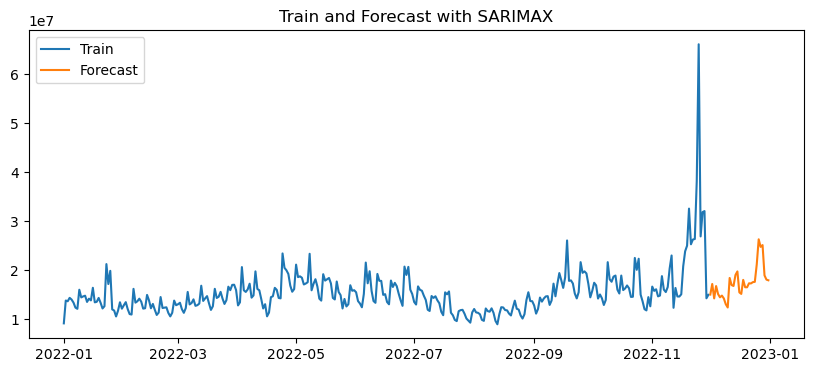

In [80]:
# Plot the future predictions - future predictions
plot_future(y['2022'], future_predictions, "SARIMAX")